In [1]:
# Torch imports
import torch
from torchvision.transforms import v2

# File reading
import os
import pickle
from glob import glob

# Utils
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt

# 1. Global Annotations File 

In [27]:
# Annotations structure
file = './datasets/Room_all_agents/Room1/Setting1/8m/episode_0001/episode_0001.pkl'
with open(file, 'rb') as f:
    df = pickle.load(f)
    display(df.head())

,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,robot_1_rel_pos_x,robot_1_rel_pos_y,robot_1_in_fov,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
1,1,1,2.5,0.0,-2.499364,0.000094,0.117077,2.107222,-0.783901,True,6.918802,0.082890,True,6.357754,0.892982,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
2,1,2,2.5,0.0,-2.497246,0.000766,0.395836,1.800532,-1.312243,True,6.669603,-1.835180,True,6.347177,-0.898825,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
3,1,3,2.5,0.0,-2.485843,0.007717,0.725341,1.269790,-1.777184,False,5.684648,-3.913701,True,5.676816,-2.914395,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
4,1,4,2.5,0.0,-2.475703,0.019575,1.031016,0.675467,-2.030959,False,4.195889,-5.452686,True,4.486544,-4.485341,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
5,1,5,2.5,0.0,-2.466661,0.039314,1.287408,0.139663,-2.092604,False,2.620631,-6.332658,False,3.149596,-5.458576,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0


In [21]:
# Filter warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Create a global annotations file
ep_dfs = []
for room in range(1, len(glob('./datasets/Room_all_agents/Room*'))+1):
    room_dir = f'./datasets/Room_all_agents/Room{room}'

    for setting in range(1, len(glob(f'{room_dir}/*'))+1):
        set_dir = f'{room_dir}/Setting{setting}'

        for agent_dir in glob(f'{set_dir}/*'):
            agent = agent_dir.split('/')[-1]

            for ep in range(1, len(glob(f'{agent_dir}/episode_*'))+1):     

                ep_dir = f'{agent_dir}/episode_{ep:04}'
                try:
                    with open(f'{ep_dir}/episode_{ep:04}.pkl', 'rb') as f:
                        df = pickle.load(f)

                        if ep not in df['episode'].unique():
                            print(f'[WARN] Fixed episode in DataFrame {ep_dir}/{ep:04}.pkl not matching the name of the directory.')
                            df['episode'] =  np.ones(df.shape[0], dtype=int) * ep

                        df.insert(0, 'agent', [agent for _ in range(df.shape[0])])
                        df.insert(0, 'setting', np.ones(df.shape[0], dtype=int) * setting)
                        df.insert(0, 'room', np.ones(df.shape[0], dtype=int) * room)
                        ep_dfs.append(df)
                except FileNotFoundError:
                    print(f'[WARN] File not found: {ep_dir}/{ep}.pkl')

ep_dfs = pd.concat(ep_dfs)
ep_dfs.index = list(range(0, ep_dfs.shape[0]))

display(ep_dfs.head())

[WARN] Fixed episode in DataFrame ./datasets/Room_all_agents/Room1/Setting3/8m/episode_0005/0005.pkl not matching the name of the directory.
[WARN] Fixed episode in DataFrame ./datasets/Room_all_agents/Room1/Setting4/8m/episode_0005/0005.pkl not matching the name of the directory.
[WARN] Fixed episode in DataFrame ./datasets/Room_all_agents/Room1/Setting5/8m/episode_0005/0005.pkl not matching the name of the directory.


,room,setting,agent,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,...,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
0,1,1,6000000,1,1,2.5,0.0,-2.511899,-0.000324,0.064005,...,0.971636,-5.042394,False,0.939695,-2.672393,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
1,1,1,6000000,1,2,2.5,0.0,-2.538352,-0.003958,0.220937,...,0.202131,-5.149991,False,0.542664,-2.781755,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
2,1,1,6000000,1,3,2.5,0.0,-2.564896,-0.012329,0.437258,...,-0.881970,-5.099983,False,-0.024519,-2.821527,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
3,1,1,6000000,1,4,2.5,0.0,-2.581863,-0.022204,0.718748,...,-2.253910,-4.679027,False,-0.768752,-2.690010,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
4,1,1,6000000,1,5,2.5,0.0,-2.578010,-0.015496,1.005735,...,-3.509466,-3.866783,False,-1.486116,-2.346344,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0


In [22]:
# Save the annotations file (will be used in the torch Dataset object)
if not os.path.exists('./datasets/Room_all_agents/annotations.pkl'):
    ep_dfs.to_pickle('./datasets/Room_all_agents/annotations.pkl')

# 2. Image Analysis

In [2]:
file = './datasets/Room_all_agents/annotations.pkl'
with open(file, 'rb') as f:
    ep_dfs = pickle.load(f)
    ep_dfs = ep_dfs[ep_dfs['room'] == 2]
    ep_dfs.reset_index(inplace=True, drop=True)
    display(ep_dfs.head())

print(f"Number of records: {ep_dfs.shape[0]}")

,room,setting,agent,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,...,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
0,2,1,6000000,1,1,2.5,0.0,-2.487847,0.000218,0.054146,...,0.399477,-2.058357,False,-1.727415,1.410629,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
1,2,1,6000000,1,2,2.5,0.0,-2.460172,0.003844,0.212251,...,0.041570,-2.091258,False,-1.512678,1.673131,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
2,2,1,6000000,1,3,2.5,0.0,-2.432260,0.012499,0.408508,...,-0.399858,-2.046972,False,-1.183808,1.955544,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
3,2,1,6000000,1,4,2.5,0.0,-2.402785,0.028176,0.571788,...,-0.764642,-1.943012,False,-0.870931,2.145500,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
4,2,1,6000000,1,5,2.5,0.0,-2.369146,0.052264,0.635774,...,-0.934406,-1.880718,False,-0.755153,2.213702,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0


Number of records: 8753


In [3]:
# Random sample as anchor
rand_idx = np.random.randint(1, ep_dfs.shape[0] + 1)

anchor_rec = ep_dfs.iloc[rand_idx]
room = anchor_rec['room']
setting = anchor_rec['setting']
agent = anchor_rec['agent']
ep = anchor_rec['episode']
step = anchor_rec['step']

f"{room}", f"{setting}", f"{ep:04}", f"{step:05}"

('2', '2', '0003', '00032')

In [4]:
anchor_rec

room                                                                 2
setting                                                              2
agent                                                          3200000
episode                                                              3
step                                                                32
target_point_x                                                     2.5
target_point_y                                                     0.0
robot_pos_x                                                  -1.816405
robot_pos_y                                                   0.038703
robot_yaw                                                    -0.011032
robot_1_rel_pos_x                                             3.909645
robot_1_rel_pos_y                                             3.072615
robot_1_in_fov                                                    True
robot_2_rel_pos_x                                             3.001616
robot_

In [5]:
# Look for positive examples in either other rooms or settings or other agents
# pos_df = ep_dfs[(ep_dfs['setting'] != anchor_rec['setting']) | (ep_dfs['episode'] != anchor_rec['episode']) | (ep_dfs['agent'] != anchor_rec['agent'])].copy()
pos_df = ep_dfs[ep_dfs.index != rand_idx].copy()
pos_df

,room,setting,agent,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,...,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
0,2,1,6000000,1,1,2.5,0.0,-2.487847,0.000218,0.054146,...,0.399477,-2.058357,False,-1.727415,1.410629,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
1,2,1,6000000,1,2,2.5,0.0,-2.460172,0.003844,0.212251,...,0.041570,-2.091258,False,-1.512678,1.673131,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
2,2,1,6000000,1,3,2.5,0.0,-2.432260,0.012499,0.408508,...,-0.399858,-2.046972,False,-1.183808,1.955544,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
3,2,1,6000000,1,4,2.5,0.0,-2.402785,0.028176,0.571788,...,-0.764642,-1.943012,False,-0.870931,2.145500,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
4,2,1,6000000,1,5,2.5,0.0,-2.369146,0.052264,0.635774,...,-0.934406,-1.880718,False,-0.755153,2.213702,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8748,2,3,8m,5,86,2.5,0.0,1.940749,0.103740,-0.132197,...,-6.194475,-2.927711,False,-5.179220,-4.400761,False,"{'scan': [[0.13120943], [0.1346703], [0.138357...",9.0,10.0,11.0
8749,2,3,8m,5,87,2.5,0.0,1.991763,0.096320,-0.157763,...,-6.163866,-3.083260,False,-5.137458,-4.532350,False,"{'scan': [[0.14208236], [0.14566554], [0.14947...",9.0,10.0,11.0
8750,2,3,8m,5,88,2.5,0.0,2.042558,0.087611,-0.183483,...,-6.128777,-3.235537,False,-5.091092,-4.658668,False,"{'scan': [[0.15766236], [0.16162385], [0.16583...",9.0,10.0,11.0
8751,2,3,8m,5,89,2.5,0.0,2.093258,0.077597,-0.207789,...,-6.097354,-3.377372,False,-5.046530,-4.772039,False,"{'scan': [[0.16784842], [0.17175904], [0.17591...",9.0,10.0,11.0


In [6]:
# Look for negative examples in other episodes of the same setting of the room
# neg_df = ep_dfs[(ep_dfs['room'] == anchor_rec['room']) & (ep_dfs['setting'] == anchor_rec['setting']) & ((ep_dfs['episode'] != anchor_rec['episode']) | (ep_dfs['agent'] != anchor_rec['agent']))].copy()
neg_df = ep_dfs[ep_dfs.index != rand_idx].copy()
neg_df

,room,setting,agent,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,...,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
0,2,1,6000000,1,1,2.5,0.0,-2.487847,0.000218,0.054146,...,0.399477,-2.058357,False,-1.727415,1.410629,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
1,2,1,6000000,1,2,2.5,0.0,-2.460172,0.003844,0.212251,...,0.041570,-2.091258,False,-1.512678,1.673131,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
2,2,1,6000000,1,3,2.5,0.0,-2.432260,0.012499,0.408508,...,-0.399858,-2.046972,False,-1.183808,1.955544,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
3,2,1,6000000,1,4,2.5,0.0,-2.402785,0.028176,0.571788,...,-0.764642,-1.943012,False,-0.870931,2.145500,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
4,2,1,6000000,1,5,2.5,0.0,-2.369146,0.052264,0.635774,...,-0.934406,-1.880718,False,-0.755153,2.213702,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8748,2,3,8m,5,86,2.5,0.0,1.940749,0.103740,-0.132197,...,-6.194475,-2.927711,False,-5.179220,-4.400761,False,"{'scan': [[0.13120943], [0.1346703], [0.138357...",9.0,10.0,11.0
8749,2,3,8m,5,87,2.5,0.0,1.991763,0.096320,-0.157763,...,-6.163866,-3.083260,False,-5.137458,-4.532350,False,"{'scan': [[0.14208236], [0.14566554], [0.14947...",9.0,10.0,11.0
8750,2,3,8m,5,88,2.5,0.0,2.042558,0.087611,-0.183483,...,-6.128777,-3.235537,False,-5.091092,-4.658668,False,"{'scan': [[0.15766236], [0.16162385], [0.16583...",9.0,10.0,11.0
8751,2,3,8m,5,89,2.5,0.0,2.093258,0.077597,-0.207789,...,-6.097354,-3.377372,False,-5.046530,-4.772039,False,"{'scan': [[0.16784842], [0.17175904], [0.17591...",9.0,10.0,11.0


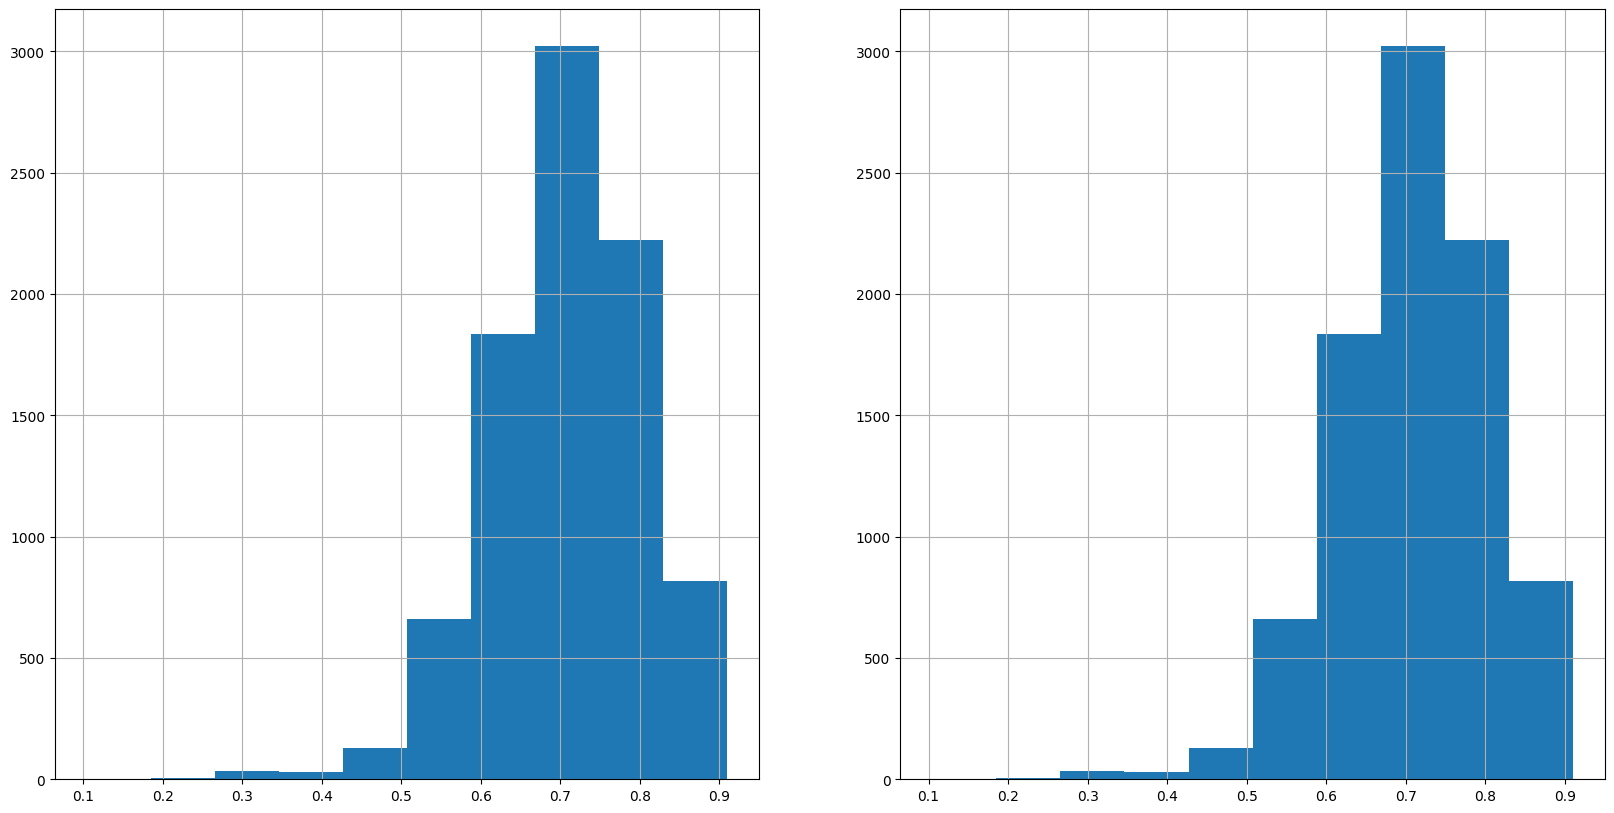

In [7]:
# Weight vector
anc_scan = anchor_rec.laser_readings['scan'].squeeze()
w = np.zeros(anc_scan.shape[0])
# In FOV readings (consider only them for binary masking)
w[64:164] += 1 
# Out of FOV readings (consider also them for soft masking)
x = np.linspace(0.0, 1.0, w[164:].shape[0])
sigmoid = 1 - 0.9*(1 / (1+np.exp(-x))) # Sigmoid 1.0 -> 0.1
w[164:] += sigmoid
w[63::-1] += sigmoid

# Normalizer
den = np.sqrt(w.sum())

# Normalized weighted Eucledian distances on LiDAR readings 
pos_l2_dist = pos_df['laser_readings'].map(lambda x: np.sqrt(np.sum(w*(anc_scan - x['scan'].squeeze())**2)) / den)
neg_l2_dist = neg_df['laser_readings'].map(lambda x: np.sqrt(np.sum(w*(anc_scan - x['scan'].squeeze())**2)) / den)

fig = plt.figure(figsize=[20,10])
ax = fig.add_subplot(1,2,1)
pos_l2_dist.hist(ax=ax);
bx = fig.add_subplot(1,2,2)
neg_l2_dist.hist(ax=bx);

-5 -5


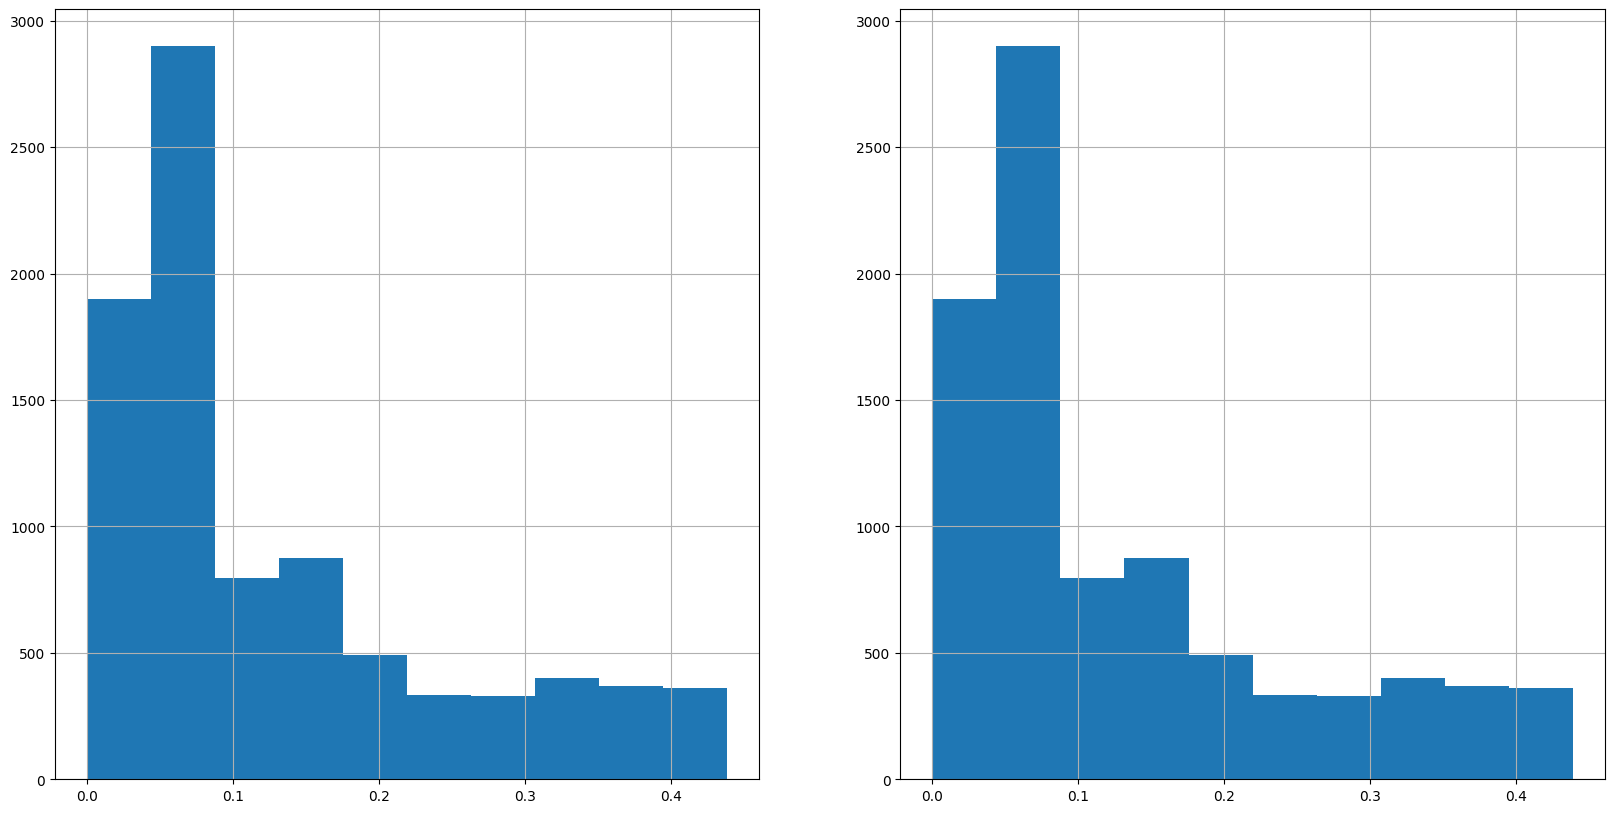

In [8]:
def opposite_corner(x, y):
    opposite_x = -5 if x >= 0 else 5
    opposite_y = -5 if y >= 0 else 5
    return opposite_x, opposite_y

# Normalized goal distance difference 
goal_pos_x, goal_pos_y = anchor_rec['target_point_x'], anchor_rec['target_point_y']
corner_x, corner_y = opposite_corner(goal_pos_x, goal_pos_y)
print(corner_x, corner_y)
max_gd = np.sqrt((goal_pos_x - corner_x)**2 + (goal_pos_y - corner_y)**2)

anchor_gd = np.sqrt((anchor_rec['robot_pos_x'] - goal_pos_x)**2 + (anchor_rec['robot_pos_y'] - goal_pos_y)**2)
pos_gd_diffs = pos_df.apply(lambda x: abs(anchor_gd - np.sqrt((x['robot_pos_x'] - goal_pos_x)**2 + (x['robot_pos_y'] - goal_pos_y)**2)), axis=1) / max_gd 
neg_gd_diffs = neg_df.apply(lambda x: abs(anchor_gd - np.sqrt((x['robot_pos_x'] - goal_pos_x)**2 + (x['robot_pos_y'] - goal_pos_y)**2)), axis=1) / max_gd

fig = plt.figure(figsize=[20,10])
ax = fig.add_subplot(1,2,1)
pos_gd_diffs.hist(ax=ax);
bx = fig.add_subplot(1,2,2)
neg_gd_diffs.hist(ax=bx);

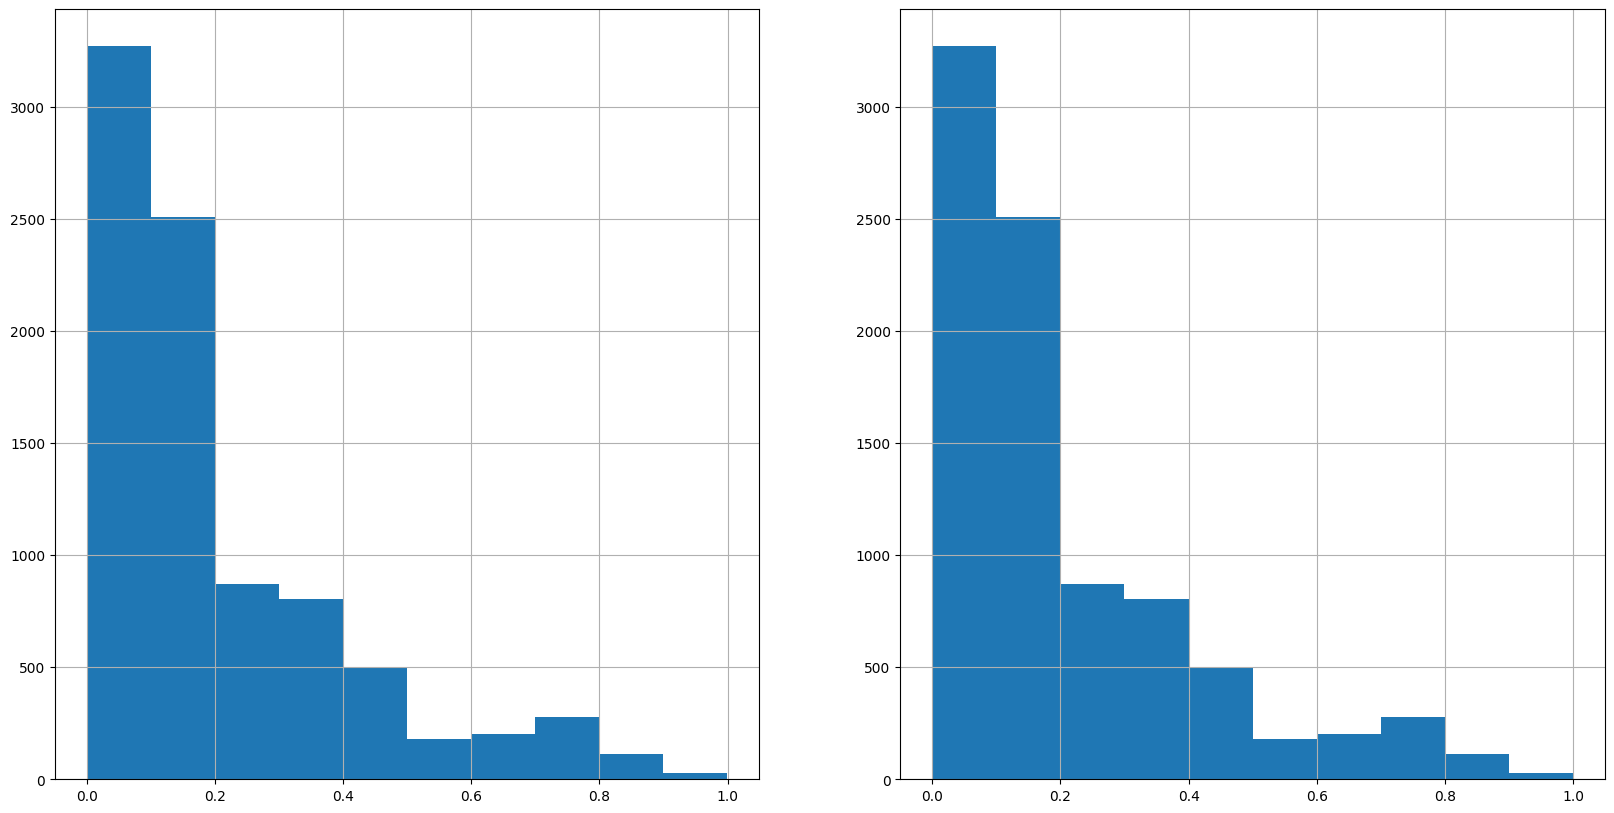

In [9]:
# Normalize angle between [-pi, pi]
def normalize_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

# Compute angle with respect to the goal considering robot's orientation
def relative_angle(record):
    # Info
    robot_x, robot_y = record['robot_pos_x'], record['robot_pos_y']
    goal_x, goal_y = record['target_point_x'], record['target_point_y']
    theta_r = record['robot_yaw'] 

    # Relative angle
    dx = goal_x - robot_x
    dy = goal_y - robot_y
    theta_g = np.arctan2(dy, dx)
    return normalize_angle(theta_g - theta_r)

# Orientation towards goal position
anchor_phi = relative_angle(anchor_rec)
pos_ori_diff = pos_df.apply(lambda x: np.abs(normalize_angle(anchor_phi - relative_angle(x))) / np.pi, axis=1) 
neg_ori_diff = neg_df.apply(lambda x: np.abs(normalize_angle(anchor_phi - relative_angle(x))) / np.pi, axis=1)

fig = plt.figure(figsize=[20,10])
ax = fig.add_subplot(1,2,1)
pos_ori_diff.hist(ax=ax);
bx = fig.add_subplot(1,2,2)
neg_ori_diff.hist(ax=bx);

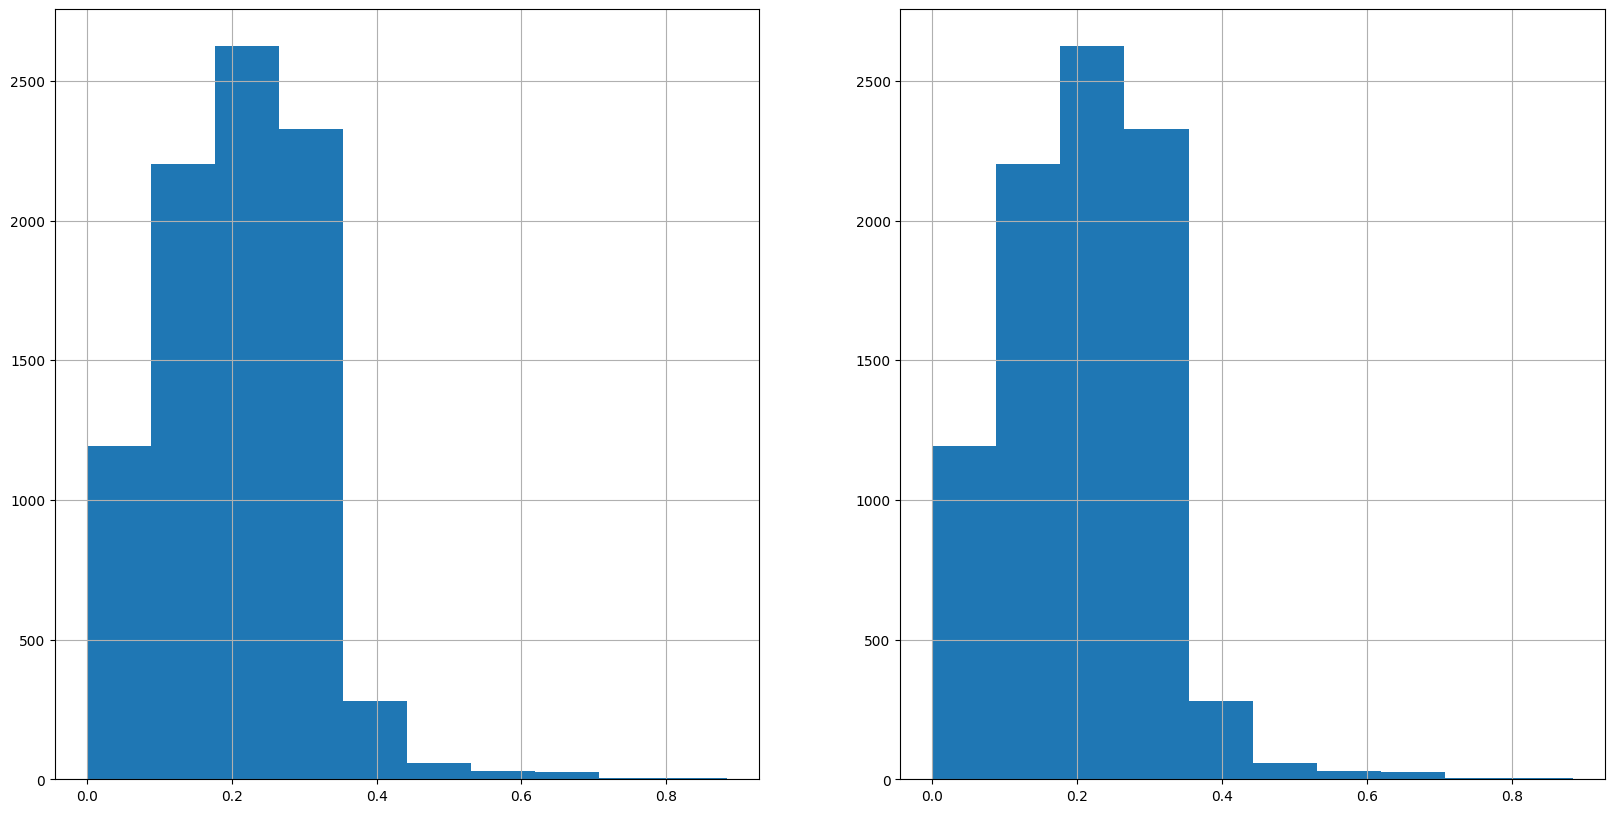

In [10]:
# Combine distances for computing similarities
pos_sim_scores = (1 - pos_l2_dist)*(1 - pos_gd_diffs)*(1 - pos_ori_diff)
neg_sim_scores = (1 - neg_l2_dist)*(1 - neg_gd_diffs)*(1 - neg_ori_diff)

fig = plt.figure(figsize=[20,10])
ax = fig.add_subplot(1,2,1)
pos_sim_scores.hist(ax=ax);
bx = fig.add_subplot(1,2,2)
neg_sim_scores.hist(ax=bx);

In [11]:
# Negative examples mining
BASE_NEG_DIST = 0.2
N_NEG_SAMPLES = 24

negative = neg_sim_scores[neg_sim_scores < BASE_NEG_DIST]
while negative.shape[0] < N_NEG_SAMPLES*2:
    BASE_NEG_DIST += 0.01
    negative = neg_sim_scores[neg_sim_scores < BASE_NEG_DIST]

print(f'Found {N_NEG_SAMPLES*2} negative examples with threshold {BASE_NEG_DIST}')

neg_ex = negative.sample(n=N_NEG_SAMPLES)
neg_ex

Found 48 negative examples with threshold 0.2


666     0.168806
5303    0.185973
5955    0.067399
8074    0.046511
7421    0.035206
5936    0.154823
2029    0.175518
5823    0.125754
5355    0.178356
7956    0.151274
3462    0.143766
7217    0.078002
8565    0.102999
5851    0.073524
8188    0.153818
3140    0.161046
1805    0.186417
8654    0.095415
658     0.081564
5099    0.109677
8355    0.184820
8078    0.053822
7592    0.169481
3697    0.115591
dtype: float64

In [12]:
negative_rec = ep_dfs.iloc[neg_ex.index]
negative_rec

,room,setting,agent,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,...,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
666,2,1,3200000,1,177,2.5,0.0,1.805981,0.502421,-0.746281,...,-0.681878,1.358378,False,-6.443662,-0.240334,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
5303,2,2,400000,4,167,2.5,0.0,-2.591125,-0.099644,1.045770,...,-3.765037,1.431411,False,-0.170203,-1.091178,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
5955,2,2,8m,5,104,2.5,0.0,1.954894,0.790668,-0.496588,...,3.793059,-2.755814,True,-6.954179,-0.285584,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
8074,2,3,400000,5,28,2.5,0.0,-1.968094,-0.187930,-2.337597,...,-0.039165,5.900510,False,1.837922,3.631592,False,"{'scan': [[0.24823987], [0.24969146], [0.25124...",9.0,10.0,11.0
7421,2,3,400000,1,189,2.5,0.0,0.216685,-2.015582,3.062098,...,0.219108,1.947037,False,-4.472452,1.951242,False,"{'scan': [[0.26119304], [0.25785625], [0.25468...",9.0,10.0,11.0
5936,2,2,8m,5,85,2.5,0.0,1.049189,1.125698,-0.238049,...,4.003952,-3.619065,True,-6.131517,1.289409,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
2029,2,1,400000,3,114,2.5,0.0,-2.399281,0.717486,-0.895752,...,2.127393,3.246244,False,1.594367,0.359976,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
5823,2,2,8m,4,81,2.5,0.0,0.985892,0.155832,-0.467153,...,3.647813,1.508324,True,-4.679471,-0.793457,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
5355,2,2,400000,4,219,2.5,0.0,-2.661609,-0.286349,1.119654,...,-4.145651,1.585123,False,0.360006,-1.111039,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
7956,2,3,400000,4,165,2.5,0.0,-3.163616,-1.293506,1.587785,...,6.312224,0.314894,True,6.907233,-0.172623,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0


In [13]:
# Retrieve negative records
neg_imgs = []
for _, neg_rec in negative_rec.iterrows():
    neg_room = neg_rec['room']
    neg_set = neg_rec['setting']
    neg_agent = neg_rec['agent']
    neg_ep = neg_rec['episode']
    neg_step = neg_rec['step']
    neg_imgs.append((f'./datasets/Room_all_agents/Room{neg_room}/Setting{neg_set}/{neg_agent}/episode_{neg_ep:04}/rgb_{neg_step:05}.png', neg_room, neg_set, neg_ep, neg_step))

In [14]:
# Positive examples mining
BASE_POS_DIST = 0.8
N_POS_SAMPLES = 12

positive = pos_sim_scores[pos_sim_scores > BASE_POS_DIST]
while positive.shape[0] < N_POS_SAMPLES*2:
    BASE_POS_DIST -= 0.01
    positive = pos_sim_scores[pos_sim_scores > BASE_POS_DIST]

print(f'Found {N_POS_SAMPLES*2} positive examples with threshold {BASE_POS_DIST}')

pos_ex = positive.sample(n=N_POS_SAMPLES)
pos_ex

Found 24 positive examples with threshold 0.6399999999999999


4132    0.689734
4137    0.702678
4119    0.884280
4127    0.696379
4139    0.647793
4114    0.681363
4455    0.645202
4116    0.696901
4117    0.774245
4115    0.659297
4143    0.741079
4142    0.739442
dtype: float64

In [15]:
positive_rec = ep_dfs.iloc[pos_ex.index]
positive_rec

,room,setting,agent,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,...,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
4132,2,2,3200000,3,41,2.5,0.0,-1.770861,0.055968,-0.203109,...,2.049896,3.859699,False,-2.198092,-1.932761,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
4137,2,2,3200000,3,46,2.5,0.0,-1.779740,0.063071,0.118129,...,3.036367,3.095690,True,-2.823482,-1.111912,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
4119,2,2,3200000,3,28,2.5,0.0,-1.804544,0.022823,-0.041531,...,2.887002,3.325777,True,-2.414234,-1.633679,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
4127,2,2,3200000,3,36,2.5,0.0,-1.810834,0.049965,0.141612,...,3.411781,2.842777,True,-2.652245,-1.131864,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
4139,2,2,3200000,3,48,2.5,0.0,-1.736770,0.064998,-0.281693,...,1.514225,4.068083,False,-2.246184,-2.183148,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
4114,2,2,3200000,3,23,2.5,0.0,-1.978848,0.026213,0.041144,...,3.395815,3.206647,True,-2.376232,-1.458033,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
4455,2,2,400000,1,11,2.5,0.0,-2.091175,0.126978,0.037635,...,6.912155,-4.900177,True,7.107191,3.763818,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
4116,2,2,3200000,3,25,2.5,0.0,-1.892883,0.021388,-0.079877,...,2.859921,3.537621,True,-2.266122,-1.728528,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
4117,2,2,3200000,3,26,2.5,0.0,-1.869945,0.021850,-0.019822,...,3.031999,3.329797,True,-2.387133,-1.586484,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
4115,2,2,3200000,3,24,2.5,0.0,-1.938800,0.025000,-0.084121,...,2.907278,3.578611,True,-2.214008,-1.741754,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0


In [16]:
# Retrieve positive records
pos_imgs = []
for _, pos_rec in positive_rec.iterrows():
    pos_room = pos_rec['room']
    pos_set = pos_rec['setting']
    pos_agent = pos_rec['agent']
    pos_ep = pos_rec['episode']
    pos_step = pos_rec['step']
    pos_imgs.append((f'./datasets/Room_all_agents/Room{pos_room}/Setting{pos_set}/{pos_agent}/episode_{pos_ep:04}/rgb_{pos_step:05}.png', pos_room, pos_set, pos_ep, pos_step))

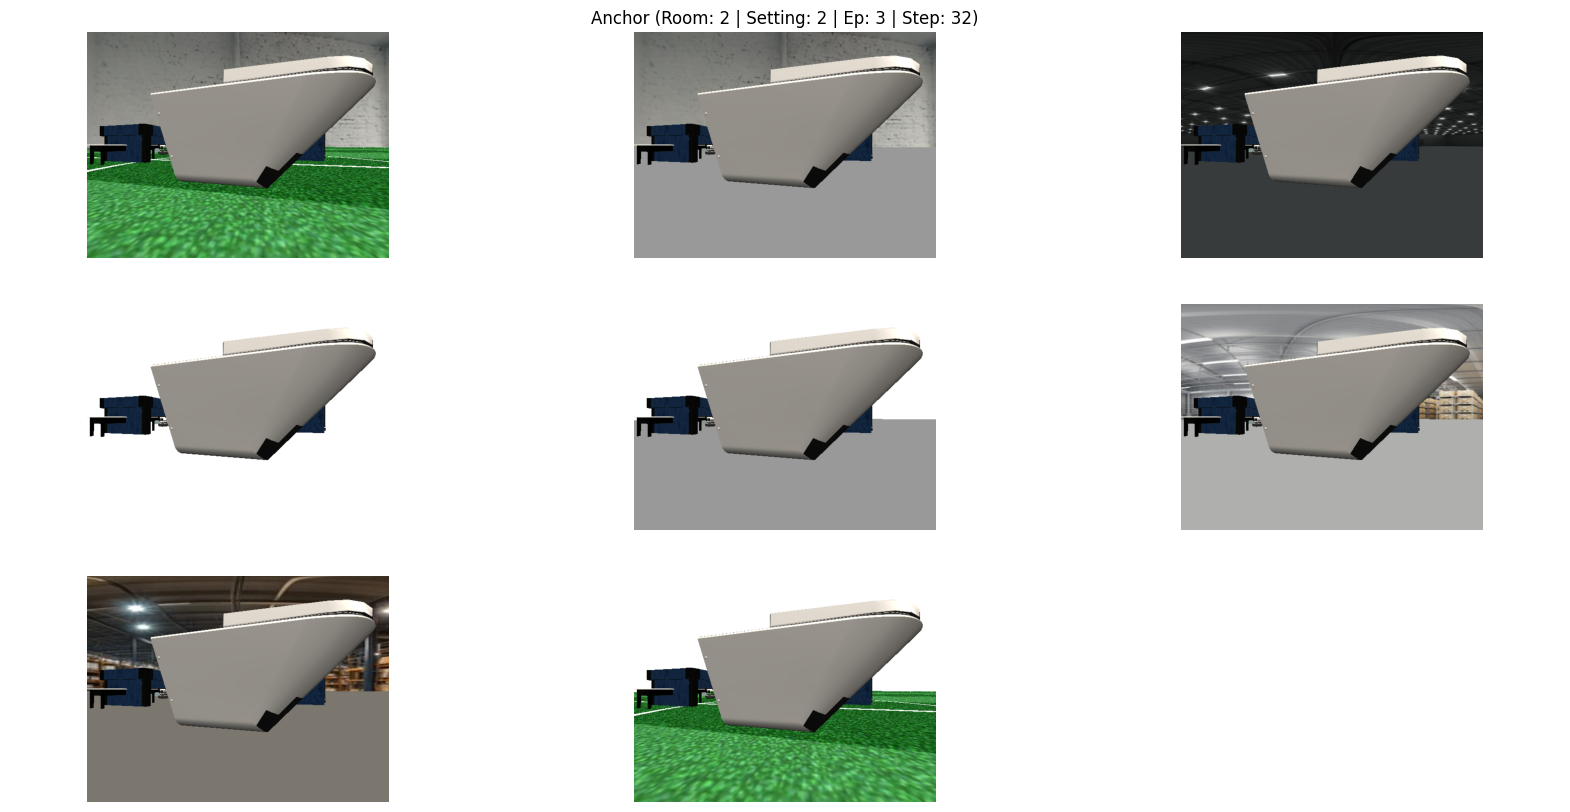

In [17]:
# Anchor image
anc_img = Image.open(f'./datasets/Room_all_agents/Room{room}/Setting{setting}/{agent}/episode_{ep:04}/rgb_{step:05}.png')
# Augmentations
aug_paths = glob(f'./datasets/Room_all_agents/Room{room}/Setting{setting}/{agent}/episode_{ep:04}/augmented_results/*_rgb_{step:05}.png')

# Plot
ROWS = 3
COLS = 3
plt.figure(figsize=[20,10])
plt.title(f'Anchor (Room: {room} | Setting: {setting} | Ep: {ep} | Step: {step})')
plt.axis('off')
plt.subplot(ROWS, COLS, 1)
plt.axis('off')
plt.imshow(anc_img)
for idx, path in enumerate(aug_paths):
    img = Image.open(path)
    plt.subplot(ROWS, COLS, idx+2)
    plt.axis('off')
    plt.imshow(img)

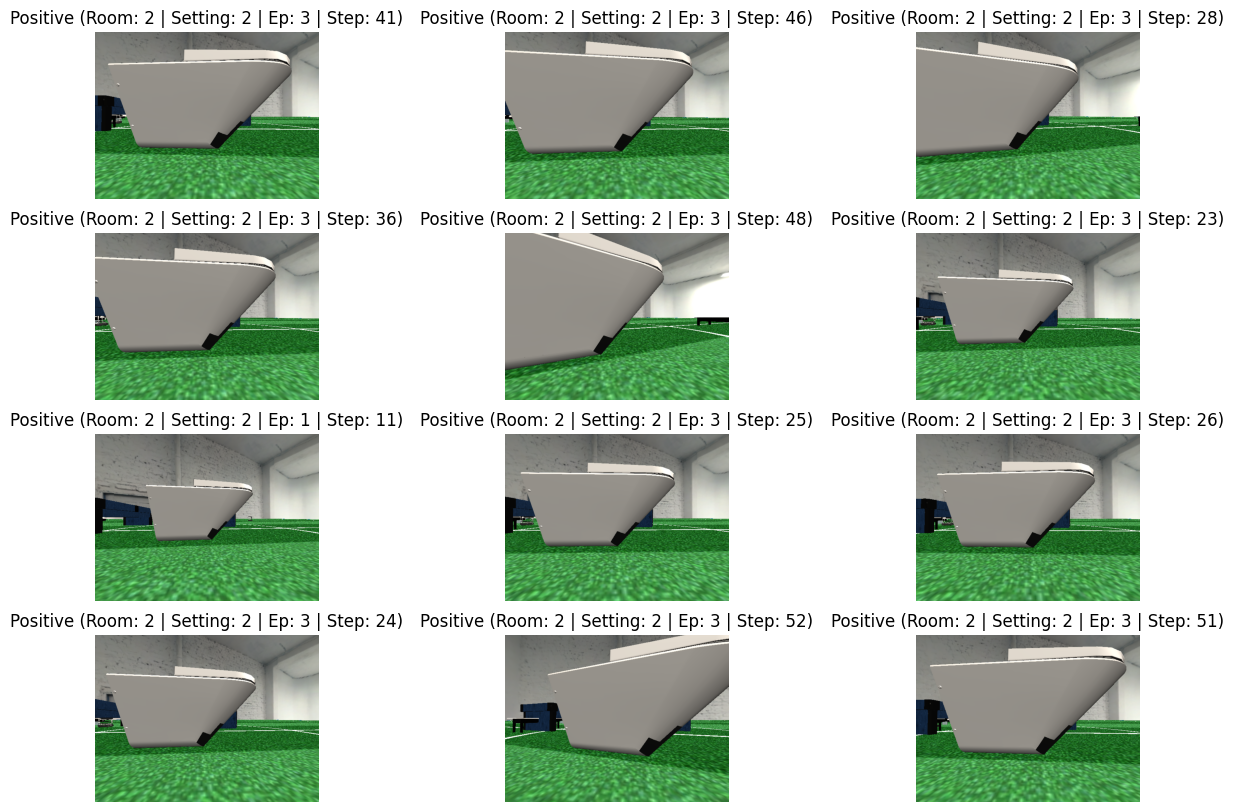

In [18]:
N_ROWS = 4
N_COLS = 3

# Plot positive examples by similarity
plt.figure(figsize=[15,10])
for idx, pos in enumerate(pos_imgs):
    img = Image.open(pos[0])
    plt.subplot(N_ROWS, N_COLS, idx+1)
    plt.title(f'Positive (Room: {pos[1]} | Setting: {pos[2]} | Ep: {pos[3]} | Step: {pos[4]})')
    plt.axis('off')
    plt.imshow(img)
plt.show();

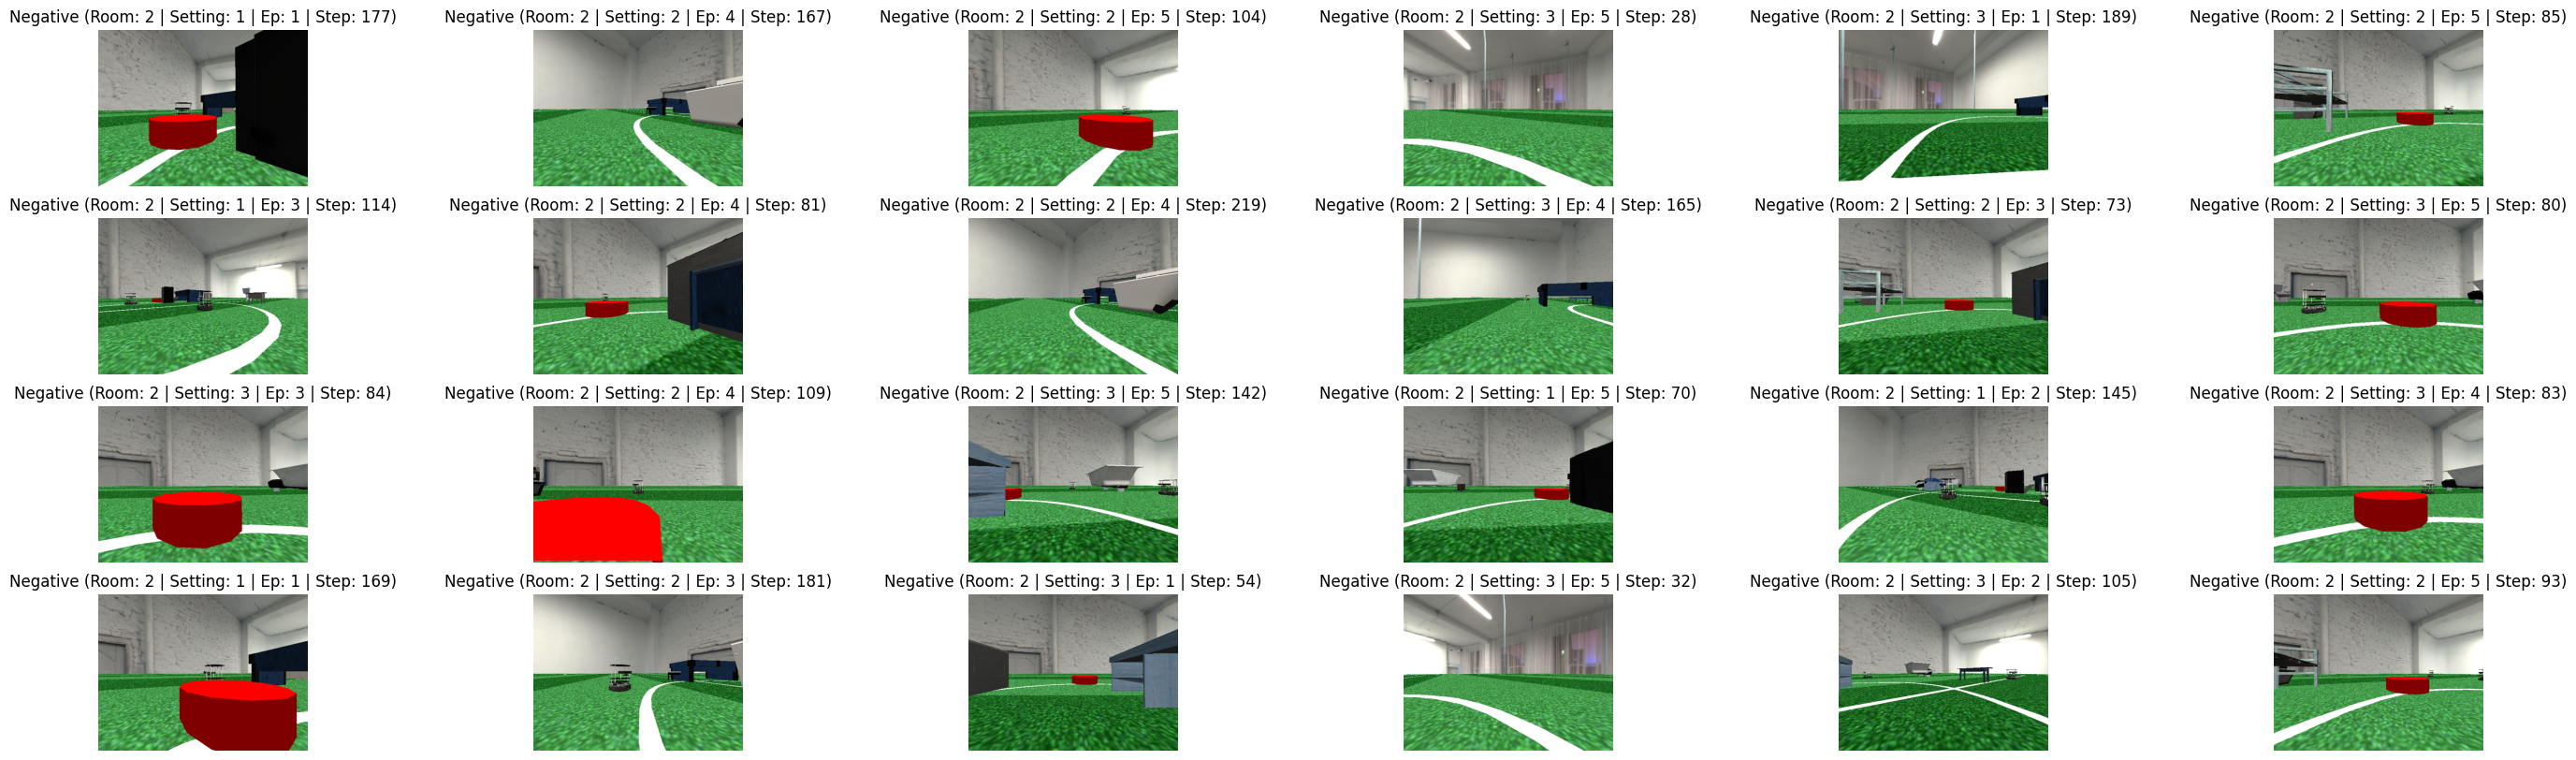

In [19]:
N_ROWS = 4
N_COLS = 6

# Plot negative examples by similarity
plt.figure(figsize=[35,10])
for idx, neg in enumerate(neg_imgs):
    img = Image.open(neg[0])
    plt.subplot(N_ROWS, N_COLS, idx+1)
    plt.title(f'Negative (Room: {neg[1]} | Setting: {neg[2]} | Ep: {neg[3]} | Step: {neg[4]})')
    plt.axis('off')
    plt.imshow(img)
plt.show();